In [1]:
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.models import Model
from tensorflow.keras.layers import concatenate

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(tf.config.list_physical_devices())

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
members_param = [
    {
        "model_name": "general",
        "file_path": "./models/medium_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 224,
        "img_height":160
    },
    {
        "model_name": "simple",
        "file_path": "./models/simple_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 160,
        "img_height":160
    },
    {
        "model_name": "grayscale",
        "file_path": "./models/grayscale_best.hdf5",
        "class_names": ['arowana', 'betta', 'goldfish', 'flowerhorn'],
        "img_width": 80,
        "img_height":60,
        "channels":1
    }
#     ,
#     {
#         "model_name": "arowana",
#         "file_path": "./models/arowana_best.hdf5",
#         "class_names": ['arowana', 'not arowana'],
#         "img_width": 128,
#         "img_height":128
#     },
#     {
#         "model_name": "betta",
#         "file_path": "./models/betta_best.hdf5",
#         "class_names": ['betta', 'not betta'],
#         "img_width": 128,
#         "img_height":128
#     },
#     {
#         "model_name": "goldfish",
#         "file_path": "./models/goldfish_best.hdf5",
#         "class_names": ['goldfish', 'not goldfish'],
#         "img_width": 128,
#         "img_height":128
#     },
#     {
#         "model_name": "flowerhorn",
#         "file_path": "./models/luohan_best.hdf5",
#         "class_names": ['flowerhorn', 'not flowerhorn'],
#         "img_width": 128,
#         "img_height":128
#     }
]

modelname   = 'ensemble'
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
IMG_WIDTH = 224
IMG_HEIGHT = 160
CHANNELS = 3
SEED = 42
N_LABELS = 4
EPOCHS = 15
OPT_IDX = 2
ACTIVATION = 'softmax'

class_names = ''
modelname = modelname+"_"+ACTIVATION+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001), optimizers.Adam(learning_rate=0.001)]
optmz = optmzs[OPT_IDX]

In [4]:
def readImagesFromDir(base_img_path='dataset/clean/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    images = {}
    image_string = tf.io.read_file(filename)
    
#     image_resized = tf.image.resize_with_pad(image_decoded, IMG_HEIGHT, IMG_WIDTH, antialias=False)
#     image_normalized = image_resized / 255.0
    for i,m in enumerate(members_param):
        ch = m.get("channels", 3)
        image_decoded = tf.image.decode_jpeg(image_string, channels=ch)
        image_resized = tf.image.resize_with_pad(image_decoded, m["img_height"], m["img_width"], antialias=False)
        image_normalized = image_resized / 255.0
        images["input_"+str(i)] = image_normalized
        
    return images, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
#     imageDS = 
    
#     labelDS = tf.data.Dataset.from_tensor_slices(labels)
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        #dataset = dataset.take(BATCH_SIZE)
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        #dataset = dataset.repeat()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        #dataset = dataset.repeat()
        
    # Batch the data for multiple steps    
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset
    
def visualize_image(original, augmented):
    org_img = tf.keras.utils.array_to_img(original)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_img)

    aug_img = tf.keras.utils.array_to_img(augmented)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_img)


def predict_new_image(model, img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
#     load and show the image
    image = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(image)
    plt.show()

#     predict with the model
    images = []

    for i, m in enumerate(members_param):
        grayscale = m.get("channels", 3) == 1
        img = tf.keras.utils.load_img(
            img_file, target_size=None, keep_aspect_ratio=True, grayscale=grayscale
        )
        img_array = tf.keras.utils.img_to_array(img)
        image_resized = tf.keras.preprocessing.image.smart_resize(
            img_array, size=(m["img_height"], m["img_width"]))
        image_normalized = image_resized / 255.0
        images.append(np.expand_dims(image_normalized, 0))

    predictions = model.predict(images)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [5]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['arowana', 'betta', 'goldfish', 'luohan']
0. arowana
1. betta
2. goldfish
3. luohan
(6705, 4)
(1677, 4)


In [6]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

dataset/clean/luohan/Flowerhorn11063.jpg [0 0 0 1]
dataset/clean/arowana/Arowana_100860.jpg [1 0 0 0]
dataset/clean/goldfish/Goldfish2376.jpg [0 0 1 0]
dataset/clean/goldfish/Goldfish2171.jpg [0 0 1 0]
dataset/clean/goldfish/Goldfish2720.jpg [0 0 1 0]
dataset/clean/luohan/Flowerhorn10058.jpg [0 0 0 1]
dataset/clean/arowana/Arowana_100466.jpg [1 0 0 0]
dataset/clean/goldfish/Goldfish1372.jpg [0 0 1 0]
dataset/clean/goldfish/Goldfish2564.jpg [0 0 1 0]
dataset/clean/luohan/Flowerhorn12115.jpg [0 0 0 1]


In [7]:
# train_ds = []
# val_ds = []

train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)

# for images, labels in train_ds.take(1):
#     print("Shape of features array:", images.numpy().shape)
#     print("Shape of labels array:", labels.numpy().shape)
#     #plt.imshow(f.numpy().astype("uint8"))
#     for i in range(5):
#         ax = plt.subplot(2, 3, i + 1)
#         img = tf.keras.utils.array_to_img(images[i])
#         plt.imshow(img)
#         plt.title(class_names[np.argmax(labels[i])])
#         plt.axis("off")

In [8]:
def add_prefix(model, prefix: str, i:str, custom_objects=None):
    config = model.get_config()
    new_to_old = {}
    for layer in config['layers']:
#         print(layer)
        new_name = prefix + i + layer['config']['name']
        if layer['class_name']=='InputLayer':
            new_name = "input_"+i
        new_to_old[new_name] = layer['config']['name']
#         layer['name'] = new_name
        layer['config']['name'] = new_name
    if config['name'].startswith('sequential'):
        new_model = tf.keras.Sequential().from_config(config, custom_objects)
    else:
        new_model = tf.keras.Model().from_config(config, custom_objects)
    for layer in new_model.layers:
        layer.set_weights(model.get_layer(new_to_old[layer.name]).get_weights())
    
    return new_model

# load models from file
def load_all_models(members_param):
    all_models = list()
    prefix = "ensemble_"
    
    for i, m in enumerate(members_param):
        # define filename for this ensemble
        filename = m["file_path"]
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(add_prefix(model,prefix,str(i)))
        print('>loaded %s' % filename)
    return all_models
 
# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(12, activation='relu')(merge)
#     hidden = Dense(10, activation='relu')(hidden)
    output = Dense(N_LABELS, activation=ACTIVATION)(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)

    # compile
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model
member_models = load_all_models(members_param)
model = define_stacked_model(member_models)
model.summary()

>loaded ./models/medium_best.hdf5
>loaded ./models/simple_best.hdf5
>loaded ./models/grayscale_best.hdf5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 160, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 ensemble_0sequential_9 (Sequen  (None, 160, 224, 3)  0          ['input_0[0][0]']                
 tial)                                                                                            
                                                                                                  
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                     

                                                                                                  
 ensemble_1conv2d_3 (Conv2D)    (None, 20, 20, 16)   9232        ['ensemble_1dropout_1[0][0]']    
                                                                                                  
 ensemble_2conv2d_344 (Conv2D)  (None, 15, 20, 32)   4640        ['ensemble_2dropout_332[0][0]']  
                                                                                                  
 ensemble_0max_pooling2d_31 (Ma  (None, 10, 14, 64)  0           ['ensemble_0conv2d_31[0][0]']    
 xPooling2D)                                                                                      
                                                                                                  
 ensemble_1max_pooling2d_3 (Max  (None, 10, 10, 16)  0           ['ensemble_1conv2d_3[0][0]']     
 Pooling2D)                                                                                       
          

In [9]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_json      = folderpath + modelname + ".json"
with open(model_json, "w") as json_file:
    json_file.write(model.to_json())
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/arbitrator_softmax_15_32_2_2022-10-30_18-12-08.hdf5
Path to log:   models/arbitrator_softmax_15_32_2_2022-10-30_18-12-08.csv


In [10]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/arbitrator_softmax_15_32_2_2022-10-30_18-12-08_plot.png


In [11]:
import time as time

start = time.time()
history = model.fit(train_ds,                            # Training data and label
          validation_data=val_ds,   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

end = time.time()
duration = round(((end - start)/60), 2)
print("duration = ", duration, " minutes")

Epoch 1/15
210/210 [==============================] - 35s 136ms/step - loss: 0.8951 - accuracy: 0.7454 - val_loss: 0.4571 - val_accuracy: 0.9845
Epoch 2/15
210/210 [==============================] - 26s 120ms/step - loss: 0.2587 - accuracy: 0.9809 - val_loss: 0.1041 - val_accuracy: 0.9881
Epoch 3/15
210/210 [==============================] - 28s 131ms/step - loss: 0.1042 - accuracy: 0.9809 - val_loss: 0.0583 - val_accuracy: 0.9899
Epoch 4/15
210/210 [==============================] - 28s 124ms/step - loss: 0.0731 - accuracy: 0.9851 - val_loss: 0.0453 - val_accuracy: 0.9905
Epoch 5/15
210/210 [==============================] - 27s 127ms/step - loss: 0.0684 - accuracy: 0.9831 - val_loss: 0.0401 - val_accuracy: 0.9917
Epoch 6/15
210/210 [==============================] - 28s 126ms/step - loss: 0.0596 - accuracy: 0.9854 - val_loss: 0.0377 - val_accuracy: 0.9911
Epoch 7/15
210/210 [==============================] - 28s 127ms/step - loss: 0.0585 - accuracy: 0.9846 - val_loss: 0.0362 - val_ac

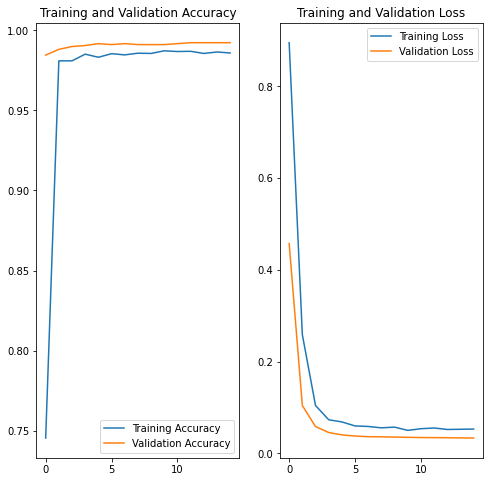

In [12]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [13]:
                                                                                # Step 1
modelGo = load_model(model_file)

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

53/53 [==============================] - 4s 63ms/step
Prediction completes.


In [14]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')


Best accuracy (on testing dataset): 99.22%
              precision    recall  f1-score   support

     arowana     0.9976    0.9976    0.9976       419
       betta     0.9877    0.9950    0.9914       404
    goldfish     0.9901    0.9877    0.9889       405
      luohan     0.9933    0.9889    0.9911       449

    accuracy                         0.9922      1677
   macro avg     0.9922    0.9923    0.9922      1677
weighted avg     0.9923    0.9922    0.9922      1677



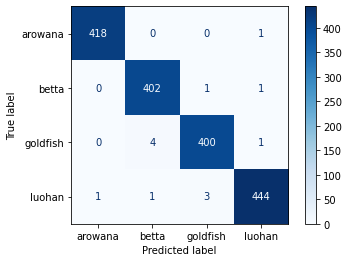

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_val_bin.argmax(axis = 1), predicts.argmax(axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(cmap = plt.cm.Blues)
plt.show()

In [16]:
resdf = pd.DataFrame()
resdf["file"] = X_val
resdf["fish"] = y_val
resdf["testout"] = testout
resdf["predout"] = predout
wrong_pred = resdf[resdf.testout !=resdf.predout]
wrong_pred

,file,fish,testout,predout
301,dataset/clean/goldfish/Goldfish1532.jpg,goldfish,2,1
483,dataset/clean/luohan/Flowerhorn10014.jpg,luohan,3,2
508,dataset/clean/goldfish/Goldfish1100.jpg,goldfish,2,1
520,dataset/clean/arowana/Arowana_101027.jpg,arowana,0,3
529,dataset/clean/goldfish/Goldfish2923.jpg,goldfish,2,1
891,dataset/clean/goldfish/Goldfish2868.jpg,goldfish,2,3
921,dataset/clean/betta/BettaFish10073.jpg,betta,1,3
930,dataset/clean/luohan/Flowerhorn11776.jpg,luohan,3,2
1206,dataset/clean/luohan/Flowerhorn12104.jpg,luohan,3,1
1326,dataset/clean/luohan/Flowerhorn11028.jpg,luohan,3,2


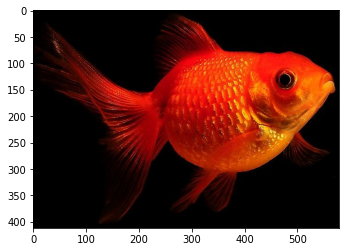

C:\Users\song\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1/1 [==============================] - 1s 567ms/step
This image most likely belongs to betta with a 47.02 percent confidence.

File: dataset/clean/goldfish/Goldfish1532.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta


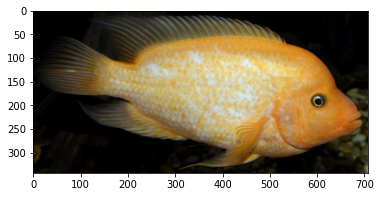

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to luohan with a 47.40 percent confidence.

File: dataset/clean/luohan/Flowerhorn10014.jpg with type luohan 
expected out 	luohan 
predicted out 	goldfish


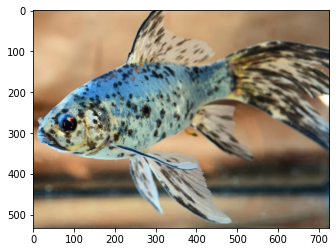

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to betta with a 43.46 percent confidence.

File: dataset/clean/goldfish/Goldfish1100.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta


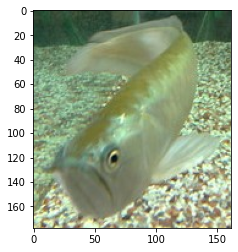

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to arowana with a 42.79 percent confidence.

File: dataset/clean/arowana/Arowana_101027.jpg with type arowana 
expected out 	arowana 
predicted out 	luohan


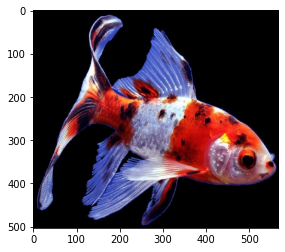

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to goldfish with a 47.22 percent confidence.

File: dataset/clean/goldfish/Goldfish2923.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta


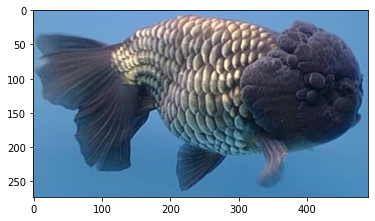

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to goldfish with a 36.73 percent confidence.

File: dataset/clean/goldfish/Goldfish2868.jpg with type goldfish 
expected out 	goldfish 
predicted out 	luohan


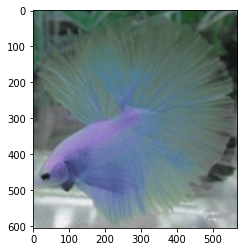

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to luohan with a 42.63 percent confidence.

File: dataset/clean/betta/BettaFish10073.jpg with type betta 
expected out 	betta 
predicted out 	luohan


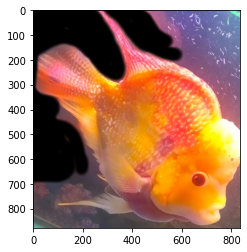

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to goldfish with a 31.20 percent confidence.

File: dataset/clean/luohan/Flowerhorn11776.jpg with type luohan 
expected out 	luohan 
predicted out 	goldfish


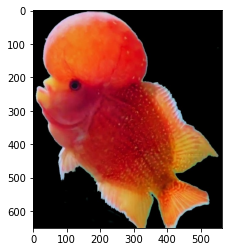

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to betta with a 47.08 percent confidence.

File: dataset/clean/luohan/Flowerhorn12104.jpg with type luohan 
expected out 	luohan 
predicted out 	betta


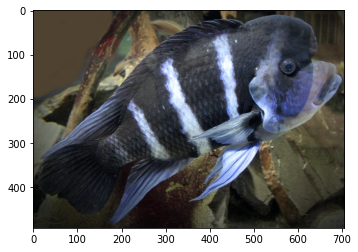

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to betta with a 27.73 percent confidence.

File: dataset/clean/luohan/Flowerhorn11028.jpg with type luohan 
expected out 	luohan 
predicted out 	goldfish


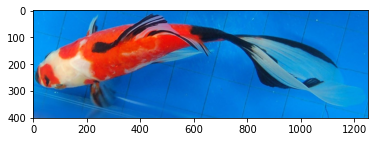

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to betta with a 30.94 percent confidence.

File: dataset/clean/goldfish/Goldfish2671.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta


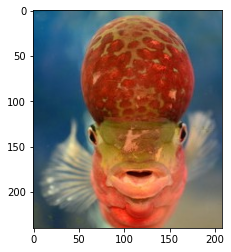

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to arowana with a 46.84 percent confidence.

File: dataset/clean/luohan/Flowerhorn11552.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana


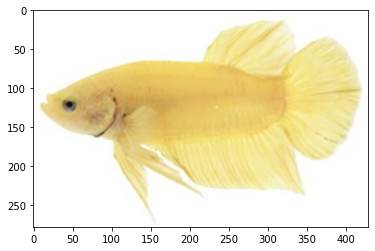

1/1 [==============================] - 0s 19ms/step
This image most likely belongs to goldfish with a 30.74 percent confidence.

File: dataset/clean/betta/BettaFish11743.jpg with type betta 
expected out 	betta 
predicted out 	goldfish


In [17]:
# make predictions

for i in range(wrong_pred.shape[0]):
    row = wrong_pred.iloc[i]
    predict_new_image(modelGo, row.file)
    print("File: {} with type {} \nexpected out \t{} \npredicted out \t{}".format(row.file, row.fish, class_names[row.testout], class_names[row.predout]))
